In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.binary import BinaryEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep_pjw as sep

from bliss.datasets.lsst import BACKGROUND

In [ ]:
def asinh_map(x, q=0.01, stretch=1, minimum=0):
    return np.arcsinh(q * (x - minimum) / stretch) / q

In [ ]:
device = torch.device("cuda:0")
TILE_SLEN = 4
PTILE_SLEN = 52
BP = 24

In [ ]:
# model
binary = BinaryEncoder().to(device).eval()
_ = binary.load_state_dict(
    torch.load(f"../../models/binary_42_42.pt", map_location=device, weights_only=True)
)
binary = binary.requires_grad_(False)

In [ ]:
# data
from bliss.datasets.io import load_dataset_npz

test_ds = load_dataset_npz("../../data/datasets/test_ds_42.npz")
test_ds.keys()

dict_keys(['images', 'noiseless', 'uncentered_sources', 'centered_sources', 'paddings', 'fluxes', 'star_bools', 'plocs', 'n_sources', 'galaxy_params', 'star_fluxes', 'galaxy_bools'])

In [ ]:
# use 1000 images for now to speedup iteration time
test_ds_sample = {p: q for p, q in test_ds.items()}
images = test_ds_sample["images"]
single_centered = test_ds_sample['centered_sources']
images.shape, single_centered.shape

(torch.Size([10000, 1, 88, 88]), torch.Size([10000, 10, 1, 88, 88]))

In [ ]:
# get snr
snrs = torch.zeros_like(test_ds_sample['fluxes'])
n_batches = test_ds_sample['n_sources'].shape[0]
for ii in range(n_batches):
    n_sources =  test_ds_sample['n_sources'][ii].item()
    for jj in range(n_sources):
        image = single_centered[ii, jj, 0, :, :].numpy()
        flux, fluxerr, _ = sep.sum_circle(image, [43.5], [43.5], 5.0, err=BACKGROUND.sqrt())
        snrs[ii, jj, 0] = flux.item() / fluxerr.item()

test_ds_sample['snr'] = snrs

In [ ]:
# get truth catalog
exclude = ("images", "uncentered_sources", "centered_sources", "noiseless", "paddings")
slen = images.shape[-1] - 2 * BP
true_cat_dict = {p: q for p, q in test_ds_sample.items() if p not in exclude}
_truth = FullCatalog(slen, slen, true_cat_dict)
truth_tile_cat = _truth.to_tile_params(TILE_SLEN, ignore_extra_sources=True)
truth = truth_tile_cat.to_full_params()
truth_tile_cat.locs.shape

torch.Size([10000, 10, 10, 2])

In [ ]:
# run binary encoder on true locations
batch_size = 50
n_images = images.shape[0]
n_batches = math.ceil(n_images / batch_size)

tile_galaxy_probs = [] 

for ii in tqdm(range(n_batches)):
    start, end = ii*50, (ii+1)*50
    bimages = images[start:end].to(device)
    btile_locs = truth_tile_cat.locs[start:end].to(device)
    tile_gprob_flat = binary.forward(bimages, btile_locs).to('cpu')
    tile_galaxy_probs.append(rearrange(tile_gprob_flat, '(n nth ntw) -> n nth ntw 1', n=50, nth=10, ntw=10))

tile_galaxy_probs = torch.concatenate(tile_galaxy_probs, axis=0)

100%|██████████| 200/200 [00:20<00:00,  9.54it/s]


In [ ]:
# create new catalog with these booleans and prob
from copy import deepcopy
tsh = 0.5
est_tiled = deepcopy(truth_tile_cat.to_dict())
est_tiled['galaxy_bools'] = tile_galaxy_probs.ge(tsh) * est_tiled['n_sources'].float().unsqueeze(-1)
est_tiled['star_bools'] = (1 - est_tiled['galaxy_bools']) * est_tiled['n_sources'].float().unsqueeze(-1)
est_tiled['galaxy_probs'] = tile_galaxy_probs  * est_tiled['n_sources'].float().unsqueeze(-1)

est_tiled_cat = TileCatalog(TILE_SLEN, est_tiled)
est = est_tiled_cat.to_full_params()

In [ ]:
# get source is on
b = truth.n_sources.shape[0]
ms = truth.max_n_sources
source_is_on = torch.zeros((b, ms))
for ii in range(b):
    n = truth.n_sources[ii]
    source_is_on[ii, :n] = 1.
mask = source_is_on.flatten().bool()


In [ ]:
# get flat list of truth, predicted bools, and probs
# also snr
probs = est['galaxy_probs'].flatten()[mask]
tgbools = truth['galaxy_bools'].flatten()[mask]
tsbools = truth['star_bools'].flatten()[mask]
egbools = est['galaxy_bools'].flatten()[mask]
esbools = est['star_bools'].flatten()[mask]
snr = truth['snr'].flatten()[mask]

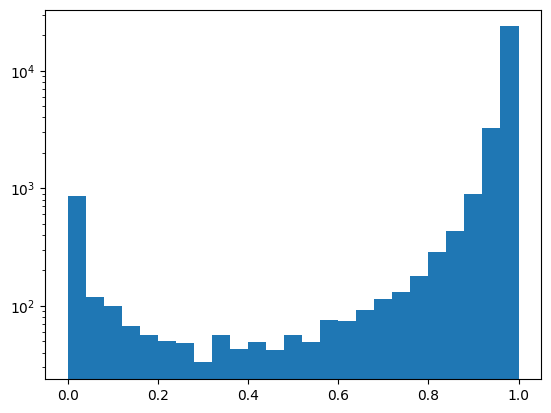

In [ ]:
plt.hist(probs, bins=25)
plt.yscale('log')

(array([  78.,  204., 1635., 5230., 4343., 3814., 3136., 2549., 2058.,
        1789., 1311., 1010.,  813.,  671.,  533.,  394.,  349.,  228.,
         192.,  167.,  140.]),
 array([0.        , 0.14285715, 0.2857143 , 0.42857143, 0.5714286 ,
        0.71428573, 0.85714287, 1.        , 1.14285719, 1.28571427,
        1.42857146, 1.57142854, 1.71428573, 1.85714281, 2.        ,
        2.14285707, 2.28571439, 2.42857146, 2.57142854, 2.71428561,
        2.85714293, 3.        ]),
 <BarContainer object of 21 artists>)

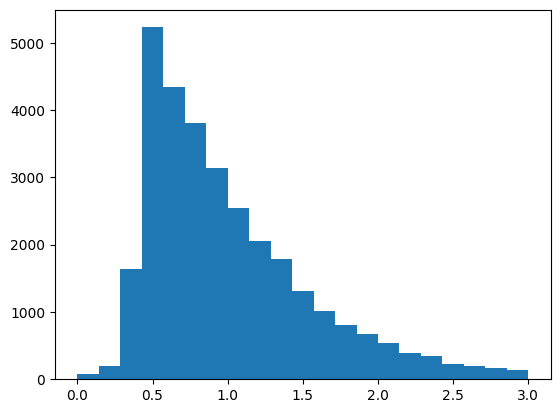

In [ ]:
plt.hist(snr.log10(), bins=21, range=(0, 3))

/home/imendoza/bliss/bliss/plotting.py:260: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


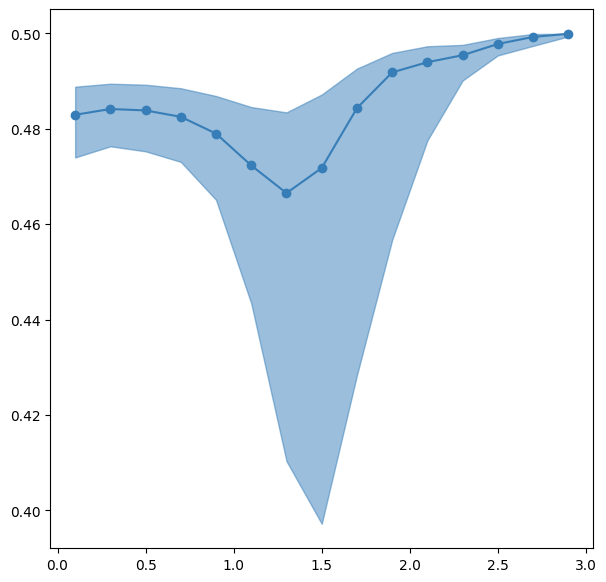

In [ ]:
# start simple, 
# scatter shade plot of probability as a function of SNR
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), torch.abs(probs - 0.5) , xlims=(0, 3), delta=0.2, qs=(0.25, 0.75))

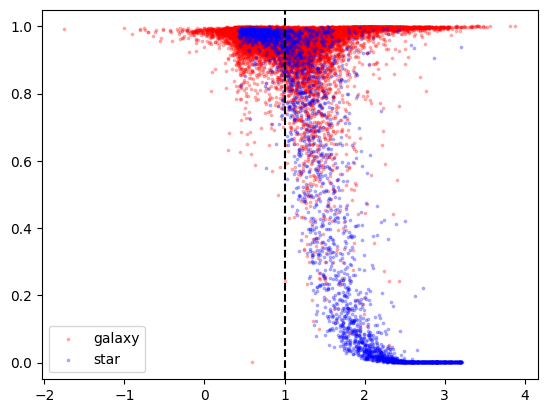

In [ ]:
galaxy_mask = tgbools.bool()
star_mask = tsbools.bool()

plt.scatter(snr.log10()[galaxy_mask], probs[galaxy_mask], marker='o', s=3, alpha=0.25, color='r', label='galaxy')
plt.scatter(snr.log10()[star_mask], probs[star_mask], marker='o', s=3, alpha=0.25, color='b', label='star')
plt.legend()
plt.axvline(1.0, color='k', linestyle='--')

In [ ]:
# # precision as a function of SNR
# tp = (egbools == tgbools) * (tgbools == 1 )
# fp = (egbools != tgbools) * (egbools ==1 )
# tn = (esbools == tsbools) * (tsbools == 1 )
# n = (esbools == 1)
# p = (egbools == 1)

In [ ]:
snr_bins1 = 10 ** torch.arange(0, 3.0, 0.2)
snr_bins2 = 10 ** torch.arange(0.2, 3.2, 0.2)
snr_bins = torch.column_stack((snr_bins1, snr_bins2))
snr_bins.shape

torch.Size([15, 2])

In [ ]:

tp_per_bin = []
nt_per_bin = [] 
p_per_bin = [] 
for snr1, snr2 in snr_bins:
    _mask = (snr > snr1) * (snr < snr2)
    _tp = (egbools == tgbools) * (tgbools == 1 ) * (egbools == 1 ) * _mask
    _p = (egbools == 1) * _mask
    _nt = (tgbools == 1 ) * _mask

    tp_per_bin.append(_tp.sum())
    p_per_bin.append(_p.sum())
    nt_per_bin.append(_nt.sum())

tp_per_bin = torch.tensor(tp_per_bin)
p_per_bin = torch.tensor(p_per_bin)
nt_per_bin = torch.tensor(nt_per_bin)

galaxies_out  = {
'tp':tp_per_bin,
'p': p_per_bin,
'nt': nt_per_bin,
}

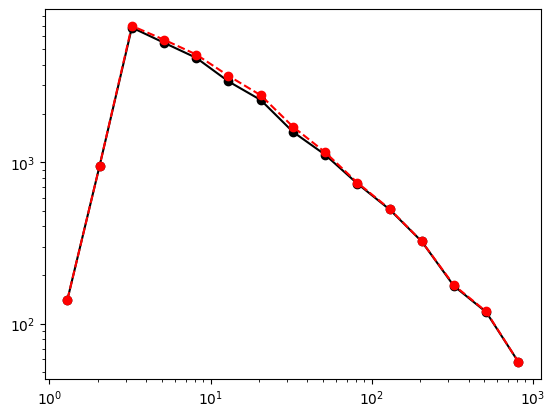

In [ ]:
# number of galaxies per bin
snr_middle = snr_bins.mean(axis=-1)

plt.plot(snr_middle, galaxies_out['nt'], '-ko')
plt.plot(snr_middle, galaxies_out['p'], '--ro')

plt.xscale('log')
plt.yscale('log')


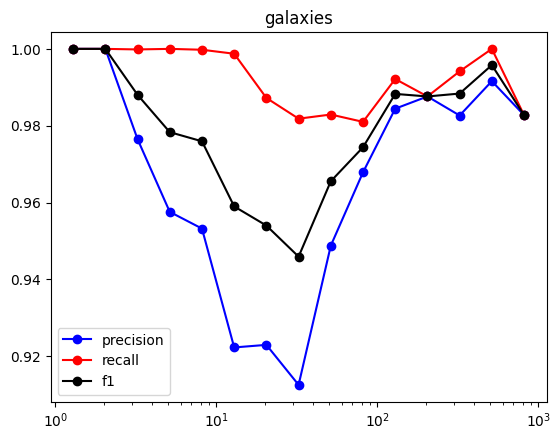

In [ ]:
snr_middle = snr_bins.mean(axis=-1)

precision = galaxies_out['tp'] / galaxies_out['p']
recall = galaxies_out['tp'] / galaxies_out['nt']
f1 = 2 / (precision**-1 + recall**-1)

plt.plot(snr_middle, precision, '-bo', label='precision')
plt.plot(snr_middle, recall, '-ro', label='recall')
plt.plot(snr_middle, f1, '-ko', label='f1')
plt.xscale('log')
plt.title("galaxies")
plt.legend()

In [ ]:
tp_per_bin = []
p_per_bin = [] 
nt_per_bin = []
for snr1, snr2 in snr_bins:
    _mask = (snr > snr1) * (snr < snr2)
    _tp = (esbools == tsbools) * (tsbools == 1 ) * _mask
    _p = (esbools == 1) * _mask
    _nt = (tsbools == 1 ) * _mask

    tp_per_bin.append(_tp.sum())
    p_per_bin.append(_p.sum())
    nt_per_bin.append(_nt.sum())

tp_per_bin = torch.tensor(tp_per_bin)
p_per_bin = torch.tensor(p_per_bin)
nt_per_bin = torch.tensor(nt_per_bin)

stars_out  = {
'tp':tp_per_bin,
'p': p_per_bin,
'nt': nt_per_bin,
}

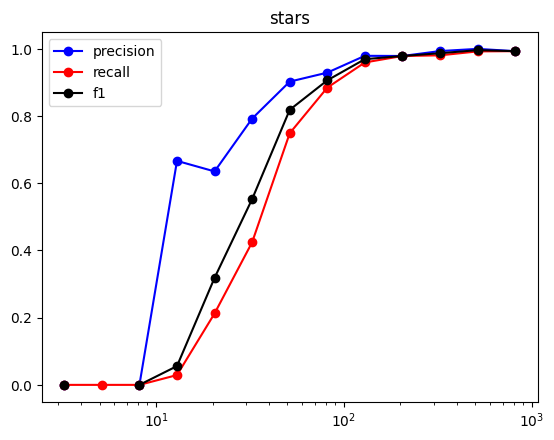

In [ ]:
snr_middle = snr_bins.mean(axis=-1)

precision = stars_out['tp'] / stars_out['p']
recall = stars_out['tp'] / stars_out['nt']
f1 = 2 / (precision**-1 + recall**-1)

plt.plot(snr_middle, precision, '-bo', label='precision')
plt.plot(snr_middle, recall, '-ro', label='recall')
plt.plot(snr_middle, f1, '-ko', label='f1')
plt.xscale('log')
plt.title("stars")
plt.legend()

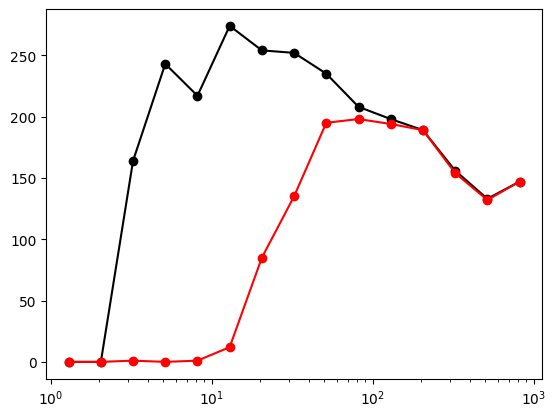

In [ ]:
# number of galaxies per bin
snr_middle = snr_bins.mean(axis=-1)

plt.plot(snr_middle, stars_out['nt'], '-ko')
plt.plot(snr_middle, stars_out['p'], '-ro')

plt.xscale('log')
# plt.yscale('log')


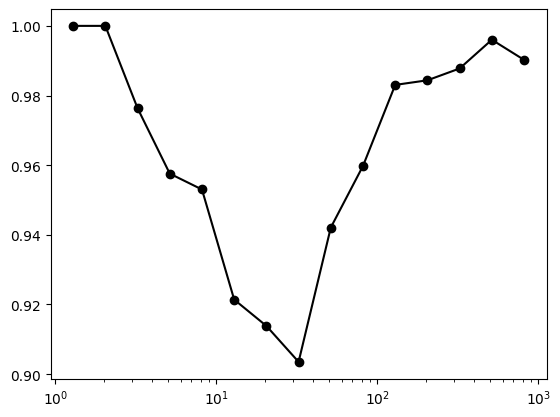

In [ ]:
# try accuracy as function of SNR

acc = (galaxies_out['tp'] + stars_out['tp']) /  (galaxies_out['p'] + stars_out['p'])
plt.plot(snr_middle, acc, '-ko')
plt.xscale('log')


# Probability weighted metrics 

In [ ]:

tp_per_bin = []
nt_per_bin = [] 
p_per_bin = [] 
for snr1, snr2 in snr_bins:
    _mask = (snr > snr1) * (snr < snr2)


    _tp =  _mask * (tgbools * (probs - 0.5).clip(0) + (1-tgbools) * (0.5 - probs).clip(0)) * 2
    _p = 2 * (probs - 0.5).abs() * _mask
    _nt =  _mask

    tp_per_bin.append(_tp.sum())
    p_per_bin.append(_p.sum())
    nt_per_bin.append(_nt.sum())

tp_per_bin = torch.tensor(tp_per_bin)
p_per_bin = torch.tensor(p_per_bin)
nt_per_bin = torch.tensor(nt_per_bin)

probs_out  = {
'tp':tp_per_bin,
'p': p_per_bin,
'nt': nt_per_bin,
}

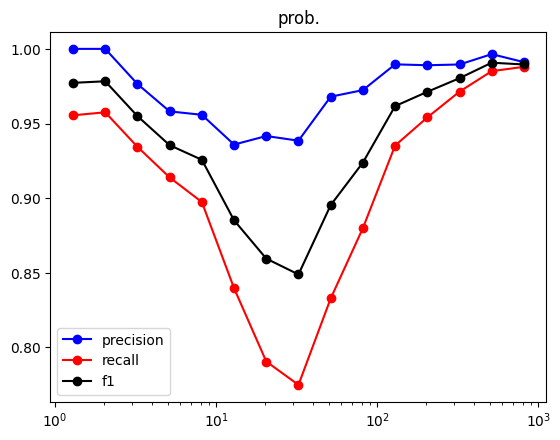

In [ ]:
snr_middle = snr_bins.mean(axis=-1)

precision = probs_out['tp'] / probs_out['p']
recall = probs_out['tp'] / probs_out['nt']
f1 = 2 / (precision**-1 + recall**-1)

plt.plot(snr_middle, precision, '-bo', label='precision')
plt.plot(snr_middle, recall, '-ro', label='recall')
plt.plot(snr_middle, f1, '-ko', label='f1')
plt.xscale('log')
plt.title("prob.")
plt.legend()